# Crypto Bot

Disclaimer: This software is built solely as an educational bot. It is not intended to provide any financial advice. DON?T FOLLOW WHAT THIS BOT SUGGESTS. Make your own research and make your own decisions.

[TL;DR]
This package allows you to:
- See the live price of your crypto (number or graph)
- See historical price of your crypto
- Get an automated technical analysis suggestion of buying/selling/retaining your crypto


Crypto Bot is a resource that allows users to keep track of their favorite cryptocurrencies in real time, observe historical data and get algorithmic technical analysis insight into the market - should you buy, retain or sell at this moment? No worries, just set your parameters in the GUI and the bot will help you make less emotional decisions.

Most cryptocurrencies from the market are available - unless you want to choose the one that the cousin of your neigbor is just starting to code. We don't have acces to that one, yet. Historical data can be retrieved in 24 hours intervals for any time range that doesn't exceed two years. If you want to get historical data from 1h intervals, the limit is data from month in the past. 
Additionally, the GUI has a programmed trading bot that will be making suggestions so that you can know when is it the best time to sell/buy/retain. 
Note: The technical indicator in this bot is the Relative Strength Index (RSI), which measures if a coin is being oversold or overbought. For more information on the RSI, visit: https://www.investopedia.com/terms/r/rsi.asp#:~:text=The%20relative%20strength%20index%20(RSI)%20is%20a%20momentum%20indicator%20used,a%20stock%20or%20other%20asset.&text=An%20RSI%20reading%20of%2030,an%20oversold%20or%20undervalued%20condition.

#### Why you should use  a trading bot?
Because you won't have to be sitting all day waiting for the market to move. Instead, you can have your bot do that for you. You don't have to miss out again on the next bull market while you're focusing your time on other things.


#### Example of use
If you want to get the current price of Ethereum, alongside a constant update of the price in a graph and how the coin has behaved hourly in the past month in order to take a decision about selling/buying. No worries, just input a couple of things in the GUI, click the associated buttons and there you go - a Warren Buffet on the making. 


## First, let's define the functions

This function takes in an argument that could be any real name of a coin. Then, it communicates with the API from CoinMarketCap.com, handles the JSON data and returns the current price in USD of the cryptocurrency. 

All functions are called with the ease of a button-click.

Note: In this example, I'm using a fake API_KEY. You should go to the website of CoinMarketCap.com and create your own API key for this to work

In [4]:
def bot_api(coin):
    global data

    parameters = {
        'slug': coin,
        'convert': "usd"
    }

    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': '312456140-af13-4aa0-ad7e-1bdb98b80470'
    }

    session = Session()
    session.headers.update(headers)

    response = session.get(url, params = parameters)

    result = json.loads(response.text)['data']
    result = list(result)
    number = result[0]
  
    result = json.loads(response.text)['data'][str(number)]['quote']['USD']['price']

    return(result)

The following function allows the GUI to display the result from the last function. Everytime the button is clicked, the last result is deleted and the current price is shown.

In [5]:
def crypto_price(coin):
    result = bot_api(coin)
    entry_results.delete(0, END)
    entry_results.insert(0, str(result))

The following function takes in the coin name and displays the official logo of your cryptocurrency on the side of the current price as a .png

Note: As of now, it only displays the logo for bitcoin, ethereum, cardano, dogecoin and litecoin. If your favorite crypto coin is not one of the above, no image is shown.

In [6]:
def add_image(coin):
    global my_image
    initial_coin = coin
    coin_path = 'logos/'
    index = '.png'
    final_coin =  coin_path + coin + index
    filepath = final_coin
    my_image = tk.PhotoImage(file=filepath)
    coin_image.delete('1.0', END)
    coin_image.image_create(END, image = my_image)


The following is an asynchronous function that uses a websocket from Binance. It take in the symbol of your favorite cryptocurrency and sends the necessary information to the update_graph() function. 

In [ ]:
async def main(symbol):
    url = "wss://stream.binance.com:9443/stream?streams=" + symbol + "usdt@miniTicker"
    async with websockets.connect(url) as client:
        while True:
            data = json.loads(await client.recv())['data']

            event_time = time.localtime(data['E'] // 1000)
            event_time = f"{event_time.tm_hour}:{event_time.tm_min}:{event_time.tm_sec}"

            print(event_time, data['c'])

            xdata.append(event_time)
            ydata.append(int(float(data['c'])))

            update_graph()
            
def run_bot2(symbol):
    if __name__ == '__main__':
        loop = asyncio.get_event_loop()
        loop.run_until_complete(main(symbol))

The following functions plot the data provided by the websocket. This allows the user to observe the live behavior of its chosen crypto in a beautiful graph. You can see a graph below as an example.

In [7]:
def show_plot():
    global ax
    global fig

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.show()

def update_graph():
    ax.plot(xdata, ydata, color='g')
    ax.legend([f"Last price: {ydata[-1]}$"])

    fig.canvas.draw()
    ax.axes.get_xaxis().set_visible(False)    
    plt.pause(0.1)

If the users wants to observe the historical candlestick behavior of a cryptocurrency (graphically), this function is called via a button in the GUI.

The user needs to specify the desired crypto symbol, an interval (1h or 24 h), the starting date and the end date. 

In [ ]:
def historical(symbol, interval, start, end):
    global df

    url = 'https://api.binance.com/api/v3/klines'

    symbol = symbol.upper()

    startTime = str(int(dt.datetime(2020,start,1).timestamp() * 1000))
    endTime = str(int(dt.datetime(2020,end,1).timestamp() * 1000))
    limit = '1000'

    req_params = {'symbol': symbol + 'USDT', 'interval': interval, 'startTime': startTime, 
    'endTime': endTime, 'limit': limit}

    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))

    df = df.iloc[:, 0:6]

    df.columns =  ['datetime', 'open', 'high', 'low', 'close', 'volume']

    df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in df.datetime]

    df['close'] = df['close'].astype(float)
    df['close'].plot()
    plt.show()
    return df

Now, we need to assing some values to the objects

In [8]:
#This is the url of the CoinMarketCao API - it tells you the latest price
url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/quotes/latest'

#Assing an empty list to the x, y of the live graph
xdata = []
ydata = []

# GUI

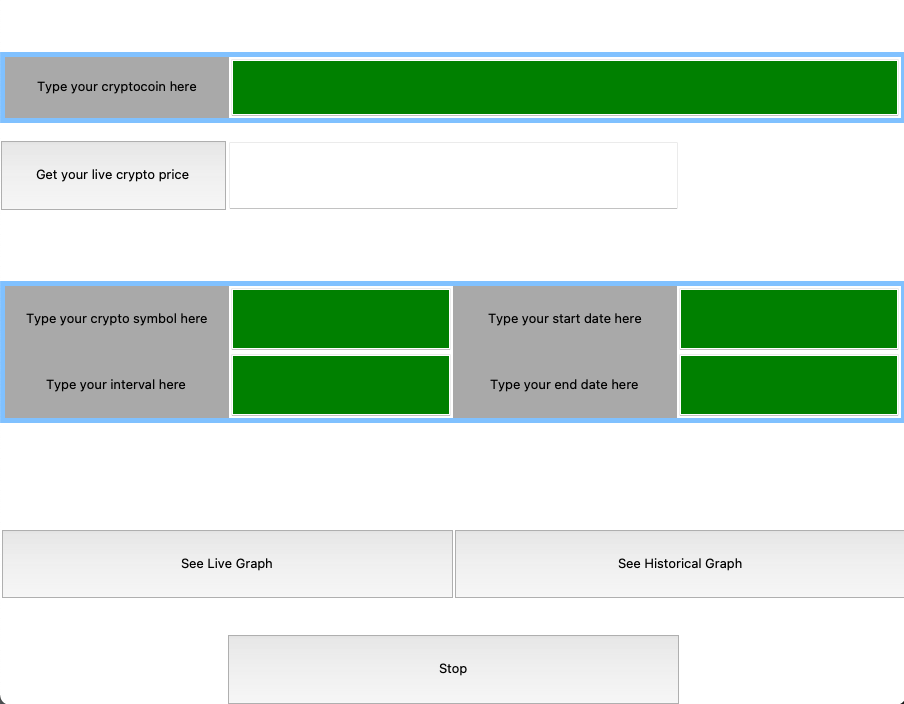

In [10]:
from IPython.display import display, Image

display(Image(filename='/Users/deborastein/Dropbox/Mi Mac (MacBook-Air-de-DEBORA.local)/Desktop/Gui.png'))